In [1]:
import cv2
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import random
import shutil
import pathlib
import itertools
import datetime
from skimage.transform import resize
from matplotlib.pyplot import imshow
from IPython.display import clear_output
import concurrent.futures
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from keras import models
from keras import layers
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras 
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from IPython.core.display import Image
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model, Model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD
from imblearn.over_sampling import RandomOverSampler 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import textwrap as tw
from pathlib import Path
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import auc,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
import tensorflow_datasets as tfds
from PIL import Image, ImageEnhance
import multiprocessing
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import LabelEncoder
import joblib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
train.columns=['index', 'labels']
train = train.drop(['index'], axis=1)
train.head()

labels
0  ApplyEyeMakeup
1   ApplyLipstick
2         Archery
3    BabyCrawling
4     BalanceBeam

In [3]:
len(train)

101

In [4]:
path=[]
for label in train.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

'../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/'

In [5]:
def feature_extraction(video_path):
    width=60
    height=60
    sequence_length=5
    frames_list=[]
    
    video_reader = cv2.VideoCapture(video_path)
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count/sequence_length), 1)
    
    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break;
            
        frame=cv2.resize(frame, (height, width))
        frame = frame/255
        
        frames_list.append(frame)
    video_reader.release()
    
    return frames_list
#---------------------------------------------------------------------------------------

def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    
    for folder in datasets:
        for file in tqdm(os.listdir(folder)):
            video_path = os.path.join(folder, file)
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index+=1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

In [6]:
images, labels = load_video(path[30:])

100%|██████████| 128/128 [00:03<00:00, 32.00it/s]


In [7]:
xtrain, xtest, ytrain, ytest=train_test_split(images, labels, test_size=0.06, random_state=10)
xtrain.shape, xtest.shape, np.array(ytrain).shape, np.array(ytest).shape

((8729, 5, 60, 60, 3), (558, 5, 60, 60, 3), (8729,), (558,))

In [8]:
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense






model = Sequential()

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2, input_shape=(xtrain.shape[1],xtrain.shape[2], xtrain.shape[3], 3)))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(Flatten())
          
model.add(Dense(60, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 5, 58, 58, 16)     11008     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 5, 29, 29, 16)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 5, 29, 29, 16)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 5, 27, 27, 16)     18496     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 5, 14, 14, 16)    0         
 3D)                                                             
                                                        

In [9]:
train = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt",sep = " ",header = None,names = ['path','class'])

In [10]:
content = []
i = 0
n = 50
while len(content) < 10 and i < 102:
    if len(train[train['class']==i]) >= n:
        df_temp = train[train['class']==i].iloc[:n]
        path = df_temp['path']
        content.append(path)
        
    i += 1
    

content = np.array(content)

In [11]:
content = content.reshape(500,)
y = np.array([i//50 for i in range(0,500)])

In [12]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    
    return videos
#--------------------------------------------------------------------------
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [13]:
xframes = read_frames("../input/ucf101/UCF101/UCF-101/",content)
xframes = select_frames(xframes, 10)

99.8
(500, 10, 128, 192, 3)


In [14]:
xtr, xte, ytr , yte = train_test_split(xframes , y , shuffle=True,test_size = 0.2,random_state = 42)
ytr = to_categorical(ytr, 10)
yte = to_categorical(yte,10)

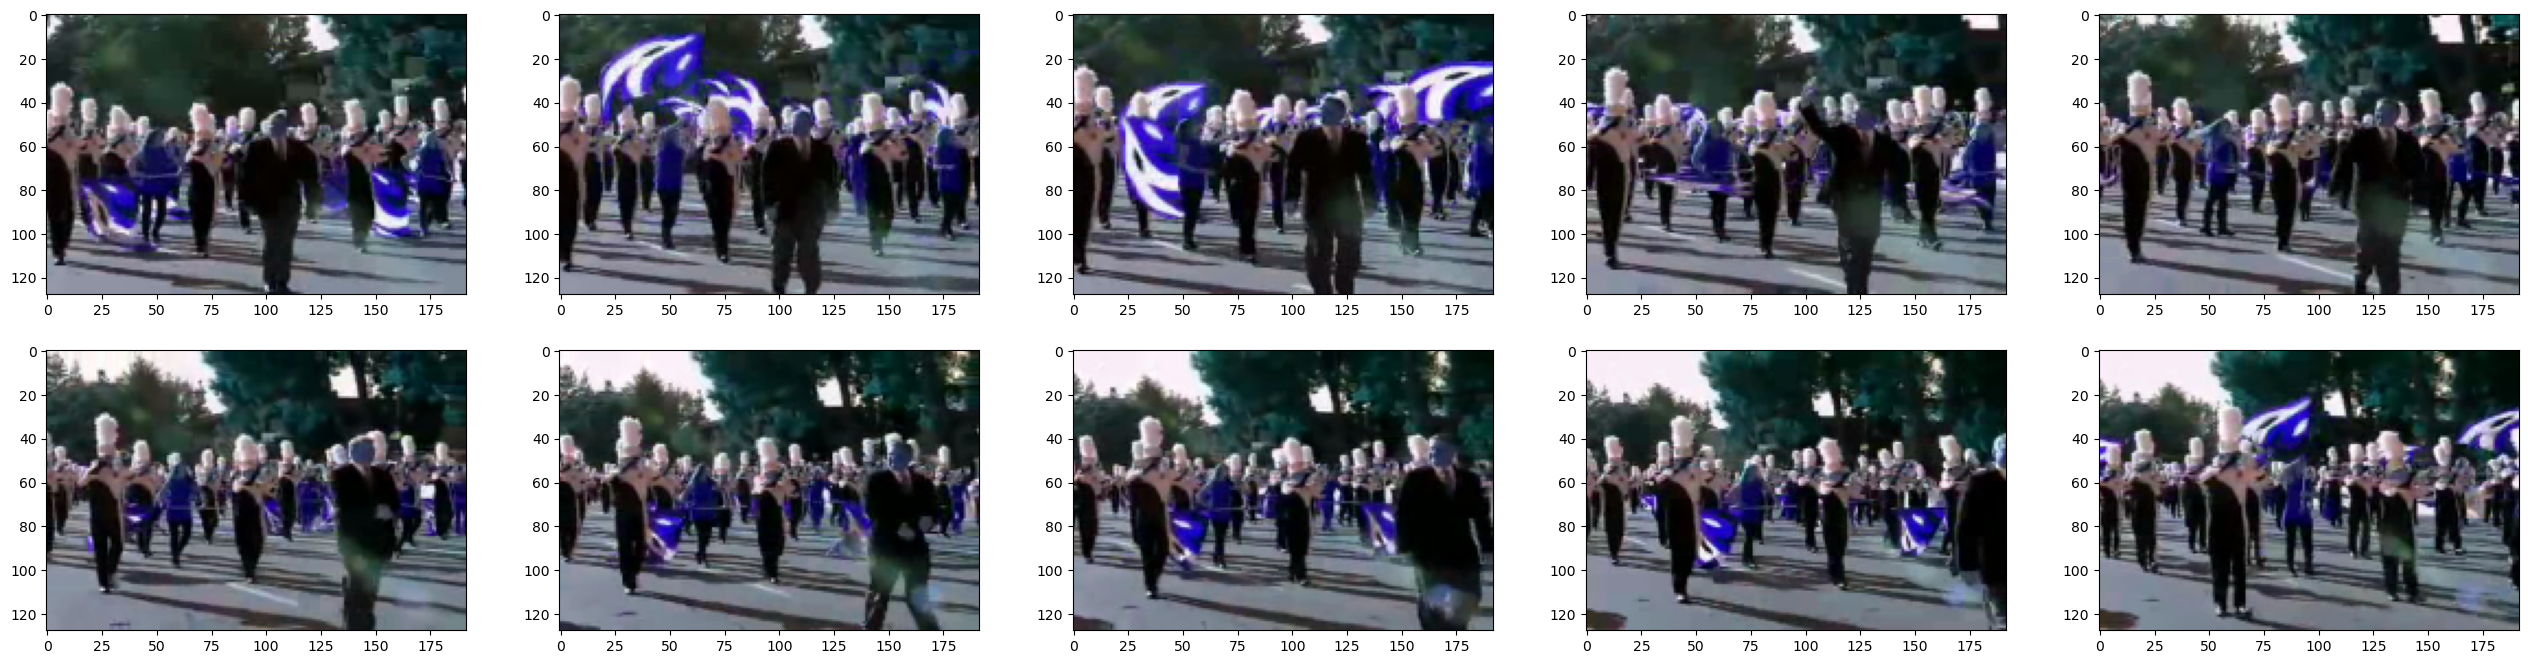

In [15]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0,len(xframes))

for i,image in enumerate(xframes[random_video_index]):
    ax = plt.subplot(2,5,i+1)
    imshow(image)

In [16]:
def list_to_stack(xs):
    xs=tf.stack(xs, axis=1)
    s = tf.shape(xs)
    
    return xs

In [17]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GRU





In [18]:
ish=(10, 128, 192, 3)
  
xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
    
    x=Lambda(lambda x: x[:, slice_indx])(inp)
    x=BatchNormalization(momentum=0.8)(x)
    x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPooling2D(pool_size=2)(x)
  
    x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    x=BatchNormalization(momentum=0.8)(x)
    x=MaxPooling2D(pool_size=2)(x)
    x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    
    xs.append(x)
  

t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
target_shape=(10,32*48*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(10, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 128, 19  0           []                               
                                2, 3)]                                                            
                                                                                                  
 lambda (Lambda)                (None, 128, 192, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 192, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 192, 3)  0           ['input_1[0][0]']            

In [19]:
plot_model(model, to_file='UCF101.png', show_shapes=True, show_layer_names=True)

In [20]:
history = model.fit(xtr, ytr, epochs=10, batch_size=10,validation_data=(xte, yte),shuffle  = True)

Epoch 1/10
40/40 [==============================] - 139s 3s/step - loss: 2.0992 - accuracy: 0.3500 - val_loss: 1.9130 - val_accuracy: 0.4800
Epoch 2/10
40/40 [==============================] - 132s 3s/step - loss: 1.7205 - accuracy: 0.6725 - val_loss: 1.6049 - val_accuracy: 0.7500
Epoch 3/10
40/40 [==============================] - 128s 3s/step - loss: 1.4278 - accuracy: 0.8375 - val_loss: 1.2864 - val_accuracy: 0.8400
Epoch 4/10
40/40 [==============================] - 132s 3s/step - loss: 1.1222 - accuracy: 0.9225 - val_loss: 1.0162 - val_accuracy: 0.9300
Epoch 5/10
40/40 [==============================] - 128s 3s/step - loss: 0.8649 - accuracy: 0.9775 - val_loss: 0.8207 - val_accuracy: 0.8900
Epoch 6/10
40/40 [==============================] - 131s 3s/step - loss: 0.6475 - accuracy: 0.9900 - val_loss: 0.6292 - val_accuracy: 0.9200
Epoch 7/10
40/40 [==============================] - 131s 3s/step - loss: 0.4908 - accuracy: 0.9950 - val_loss: 0.5218 - val_accuracy: 0.9300
Epoch 8/10
40

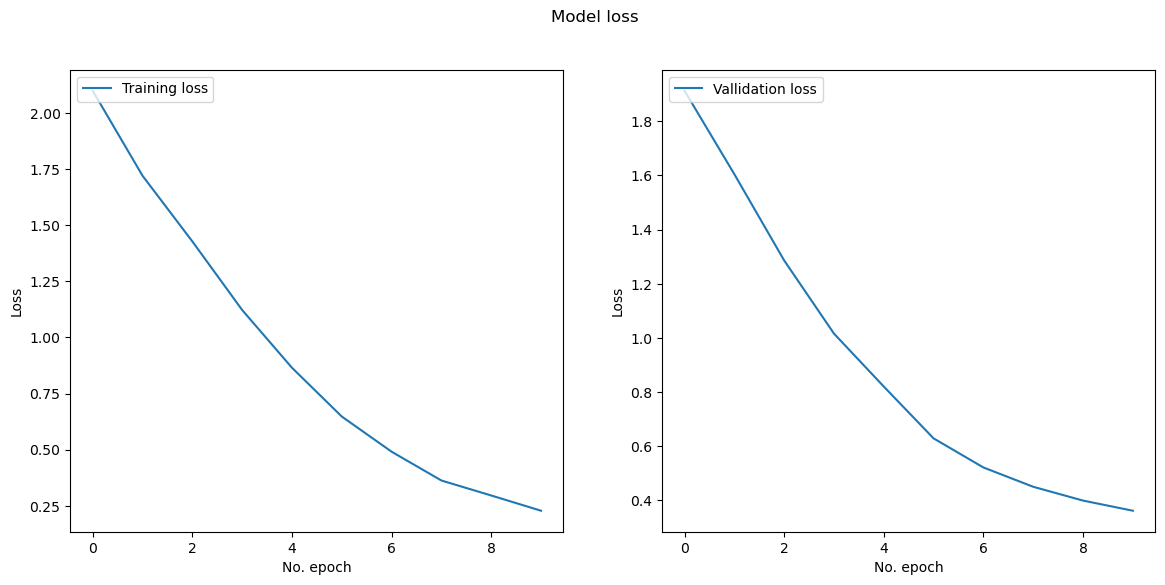

In [21]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
ax.legend(loc="upper left")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Vallidation loss')
ax.legend(loc="upper left")
fig.suptitle('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()


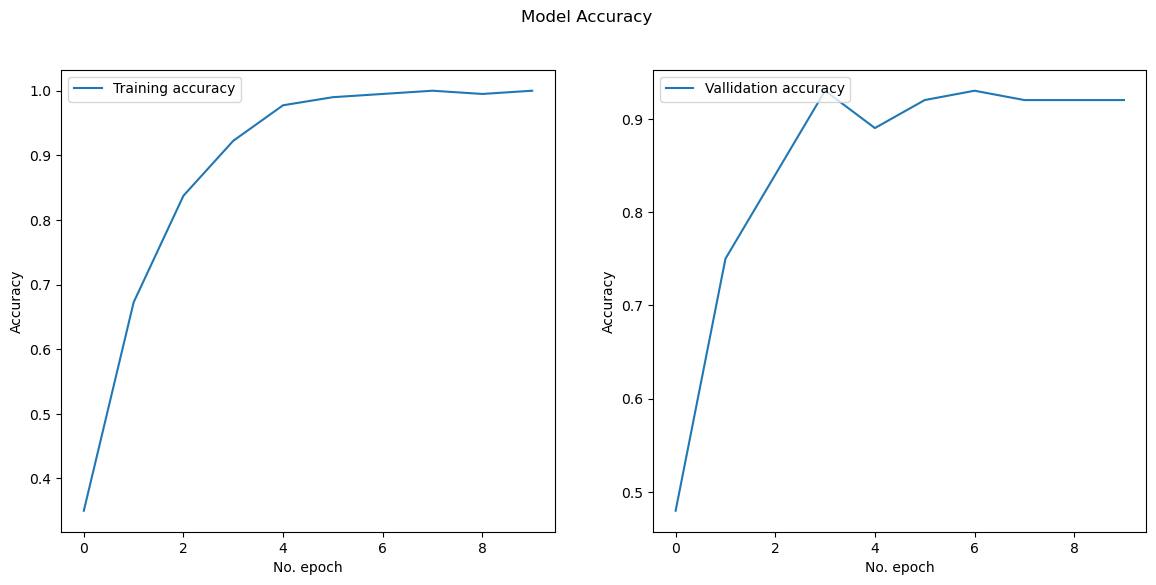

In [22]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
ax.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
ax.legend(loc="upper left")
fig.suptitle('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.show()

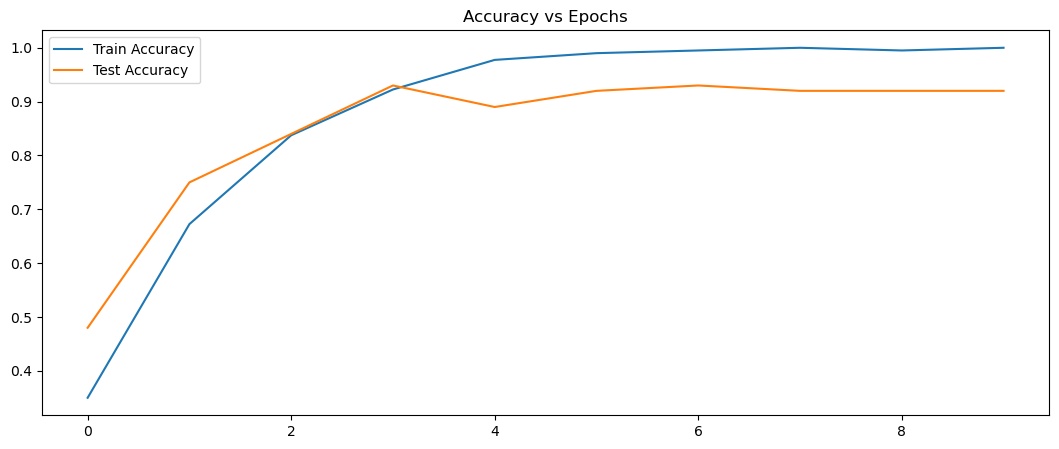

In [23]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc='best')
plt.show()

In [24]:
classes = []
for i in range(len(content)):
    class_name = content[i].split('/')[0]
    if class_name not in classes:
        classes.append(class_name)
        
num_classes = [i for i in range(10)]
class_map = dict(zip(num_classes,classes))

1/1 [==============================] - 2s 2s/step


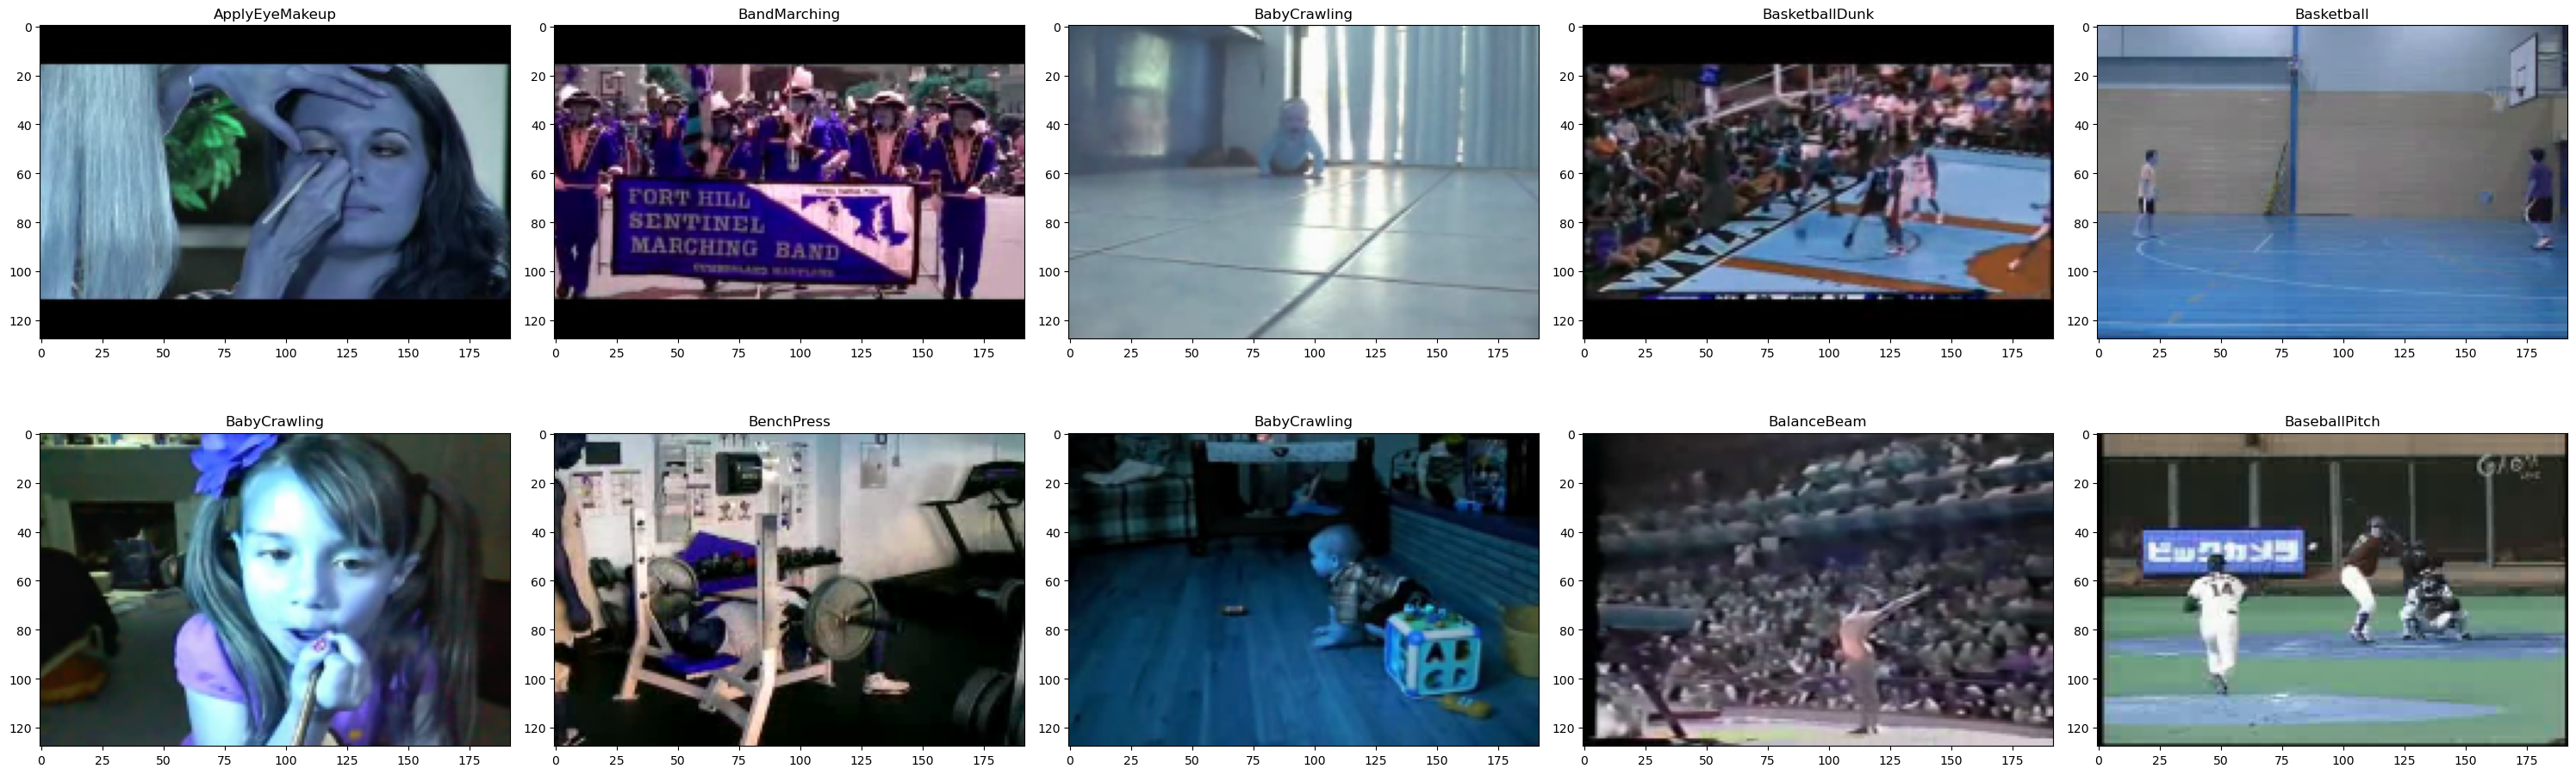

In [25]:
random_videos = np.random.randint(0,len(xte),size=(10))
predicted  = model.predict(xte[random_videos],batch_size = 10)
predicted  = np.argmax(predicted,axis=1)
fig, axes = plt.subplots(2, 5, figsize=(30, 10))

for i, rand_indx in enumerate(random_videos):
    ax = axes[i//5, i%5]
    video = xte[rand_indx]
    frame = video[np.random.randint(0,10)]
    
    ax.set_title(class_map.get(predicted[i], "Unknown"))
    ax.imshow(frame)

plt.tight_layout()
plt.show()

In [26]:
print(xte.shape)  # Should match input shape expected by the model


(100, 10, 128, 192, 3)


In [27]:
model.predict(xte[random_videos])


1/1 [==============================] - 2s 2s/step


array([[0.8885389 , 0.00386713, 0.00363884, 0.0565851 , 0.02734369,
        0.00124772, 0.00202698, 0.00158359, 0.01155815, 0.00360988],
       [0.00093422, 0.02109072, 0.01007737, 0.00391412, 0.01708276,
        0.88078415, 0.01219159, 0.00384108, 0.02081414, 0.02926977],
       [0.02468956, 0.00696556, 0.0293717 , 0.6653223 , 0.01352811,
        0.00682575, 0.01443565, 0.21559276, 0.00998187, 0.01328667],
       [0.01825517, 0.00780292, 0.0052868 , 0.02418104, 0.05321267,
        0.01004745, 0.00845753, 0.00674931, 0.8594368 , 0.0065703 ],
       [0.00178212, 0.00104985, 0.01795898, 0.02817475, 0.00303949,
        0.00171061, 0.01767693, 0.92277986, 0.00354097, 0.00228646],
       [0.11283389, 0.11040315, 0.07456478, 0.48819363, 0.02336708,
        0.03387718, 0.02571715, 0.05765696, 0.03552628, 0.03785985],
       [0.00680283, 0.04071701, 0.02547801, 0.00472039, 0.02249183,
        0.0395198 , 0.0088584 , 0.00206777, 0.00938324, 0.8399607 ],
       [0.02945929, 0.0054758 , 0.0050770

In [28]:
print(class_map)


{0: 'ApplyEyeMakeup', 1: 'ApplyLipstick', 2: 'Archery', 3: 'BabyCrawling', 4: 'BalanceBeam', 5: 'BandMarching', 6: 'BaseballPitch', 7: 'Basketball', 8: 'BasketballDunk', 9: 'BenchPress'}


In [29]:
def preprocess_video(video_path, sequence_length=10, width=128, height=192):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count / sequence_length), 1)

    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width)) / 255.0
        frames_list.append(frame)

    video_reader.release()
    return np.array(frames_list)

# Load and preprocess a sample video
video_frames = preprocess_video("sample_video.mp4")
video_frames = np.expand_dims(video_frames, axis=0) # Add batch dimension

xte = np.array(xte, dtype="float32")
predicted_probs = model.predict(xte)
predicted_class = np.argmax(predicted_probs)

print(f"Predicted Class: {class_map.get(predicted_class, 'Unknown')}")


4/4 [==============================] - 18s 3s/step
Predicted Class: Unknown


In [30]:
print(predicted_probs.shape)


(100, 10)


In [31]:


# Make predictions
predicted_probs = model.predict(xte)
predicted_class = np.argmax(predicted_probs)

# Map predicted class to actual label
class_map = {
    0: 'ApplyEyeMakeup', 1: 'ApplyLipstick', 2: 'Archery', 
    3: 'BabyCrawling', 4: 'BalanceBeam', 5: 'BandMarching',
    6: 'BaseballPitch', 7: 'Basketball', 8: 'BasketballDunk',
    9: 'BenchPress'
}

print(f"Predicted Class: {class_map.get(predicted_class, 'Unknown')}")


4/4 [==============================] - 9s 2s/step
Predicted Class: Unknown


In [32]:
model.save_weights("UCF101.h5")


In [33]:
model.save("UCF101.h5")


In [34]:
from tensorflow.keras.models import load_model
model = load_model("UCF101.h5")
